In [ ]:
import json

with open('/Users/kriskasira/Documents/RiProject/archive/Batch 3/import-videos/ann/instances.json', 'r') as file:
    podaci = json.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kriskasira/Documents/RiProject/archive/Batch 3/import-videos/ann/instances.json'

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd drive/MyDrive/panoptic

/content/drive/.shortcut-targets-by-id/1i1O5IzicKZOnN9ws7xZ6NJuTmO6MumG4/panoptic


In [ ]:
!pip install pycocotools

In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 18.8 MB/s eta 0:00:00


## Pregled Podataka

In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1i1O5IzicKZOnN9ws7xZ6NJuTmO6MumG4/panoptic'

In [ ]:
!ls codes/utils/

utils.py


In [4]:
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
from PIL import Image
import cv2
from pycocotools.coco import COCO
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models import ResNet50_Weights
from codes.utils.utils import plot_object_distribution, set_seed, save_model_weights, load_model_weights_and_optimizer
import albumentations as A
from codes.mask_rcnn.augmented_set import DatasetAugs
from datetime import datetime
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
TRAIN_ANNOTATION = './archive/train_val_test_new/coco_training.json'
VAL_ANNOTATION = './archive/train_val_test_new/coco_val.json'
TEST_ANNOTATION = './archive/train_val_test_new/coco_test.json'
IMAGES_DIR = './archive/images/'
MODEL_DIR_PATH = './output/mask_rcnn_models/'

In [6]:
NUM_CLASSES = 8
SEED = 42
set_seed(SEED)
device = 'cuda'

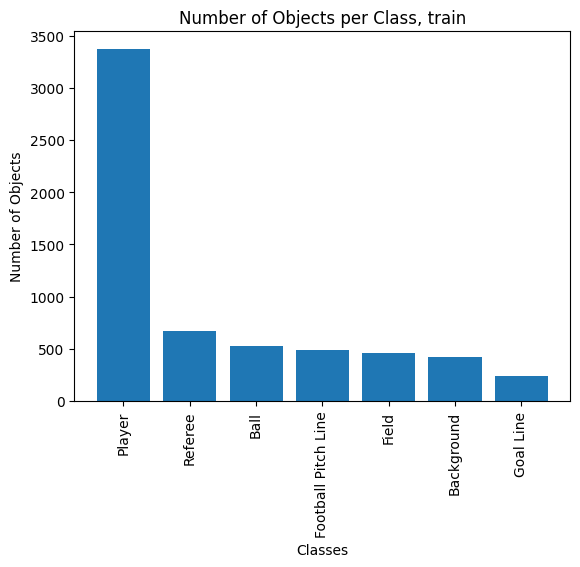

In [7]:
plot_object_distribution(TRAIN_ANNOTATION, title = "Number of Objects per Class, train")

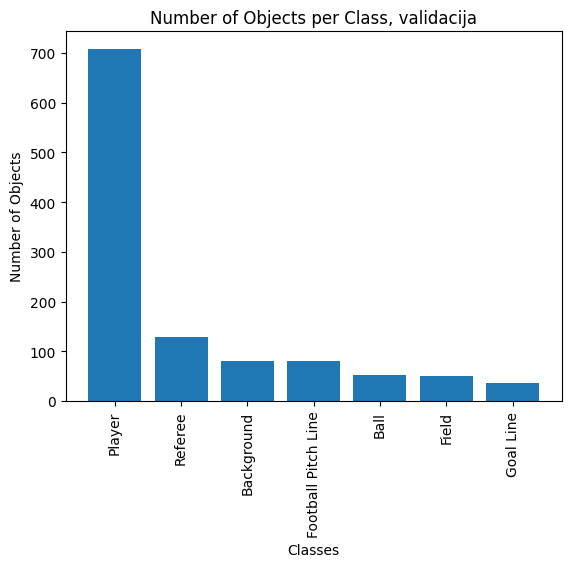

In [8]:
plot_object_distribution(VAL_ANNOTATION, "Number of Objects per Class, validacija")

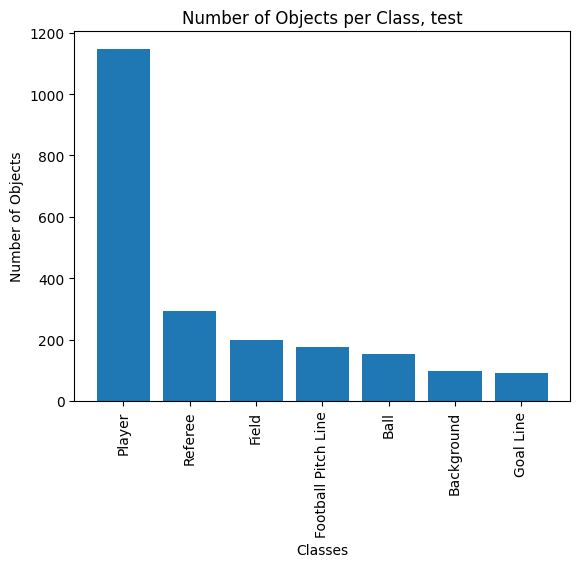

In [9]:
plot_object_distribution(TEST_ANNOTATION, "Number of Objects per Class, test")

## Definisanje modela

In [10]:
class CustomDataset(Dataset):
    def __init__(self, root, annotation_files, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco_datasets = [COCO(annotation_file) for annotation_file in annotation_files]
        self.img_ids = []
        for coco in self.coco_datasets:
            self.img_ids.extend(list(coco.imgs.keys()))
        self.img_ids = list(set(self.img_ids))


    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        for coco in self.coco_datasets:
            if img_id in coco.imgs:
                img_info = coco.loadImgs(img_id)[0]
                ann_ids = coco.getAnnIds(imgIds=img_id)
                anns = coco.loadAnns(ann_ids)
                break

        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        masks = []
        areas = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
            mask = coco.annToMask(ann)
            masks.append(mask)
            areas.append(ann['area'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.stack(masks), dtype=torch.uint8)
        areas = torch.as_tensor(areas, dtype=torch.float32)

        image_id = torch.tensor([img_id])
        iscrowd = torch.as_tensor([ann.get('iscrowd', 0) for ann in anns], dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.img_ids)



In [23]:
# small objects
def get_instance_segmentation_model(num_classes):
    backbone = resnet_fpn_backbone('resnet50', weights=ResNet50_Weights.IMAGENET1K_V1)

    anchor_generator = AnchorGenerator(
        sizes=(
            (4, 8, 16),    # P2 - High-resolution feature map for small objects
            (8, 16, 32),   # P4
            (16, 32, 64),  # P5
            (32, 64, 128),  # P6
            (128, 256, 512)
        ),
        aspect_ratios=((0.5, 1.0, 2.0),) * 5
    )

    model = MaskRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        rpn_pre_nms_top_n_train=4000,  # Increased from 2000
        rpn_post_nms_top_n_train=2000, # Increased from 1000
        rpn_pre_nms_top_n_test=2000,   # Increased from 1000
        rpn_post_nms_top_n_test=1000   # Increased from 500
    )

    return model


In [ ]:
# small objects

def get_instance_segmentation_model_small(num_classes):
    backbone = resnet_fpn_backbone('resnet50', weights=ResNet50_Weights.IMAGENET1K_V1)

    anchor_generator = AnchorGenerator(
        sizes=(
            (4, 8, 16),    # P2 - Povećane veličine za detekciju srednjih i većih objekata
            (16, 32, 64),   # P3
            (32, 64, 128),  # P4
            (64, 128, 256), # P5
            (128, 256, 512) # P6
        ),
        aspect_ratios=((0.5, 1.0, 2.0),) * 5  # Isti aspektni odnosi za sve nivoe
    )

    model = MaskRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        rpn_pre_nms_top_n_train=4000,  # Increased from 2000
        rpn_post_nms_top_n_train=2000, # Increased from 1000
        rpn_pre_nms_top_n_test=2000,   # Increased from 1000
        rpn_post_nms_top_n_test=1000   # Increased from 500
    )

    return model


## Treniranje modela

In [12]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def evaluate(model, data_loader, device, num_classes = NUM_CLASSES, testing = False):
    model.to(device)
    total_loss = 0.0
    num_batches = 0
    map_bbox = MeanAveragePrecision(iou_type="bbox", class_metrics=True)
    mAP_70_res = None

    if testing:
      map_70 = MeanAveragePrecision(iou_thresholds=[0.7, 0.8, 0.9], class_metrics=True)

    with torch.no_grad():
        for images, targets in data_loader:
            model.train()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images, targets)


            loss_dict = outputs
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
            num_batches += 1

            model.eval()
            outputs = model(images)


            for i, output in enumerate(outputs):

                preds = [{
                    'boxes': outputs[i]['boxes'].cpu(),
                    'scores': outputs[i]['scores'].cpu(),
                    'labels': outputs[i]['labels'].cpu(),
                }]

                gts = [{
                    'boxes': targets[i]['boxes'].cpu(),
                    'labels': targets[i]['labels'].cpu(),
                }]

                map_bbox.update(preds, gts)

                if testing:
                      map_70.update(preds, gts)

    mean_loss = total_loss / num_batches if num_batches > 0 else float('nan')
    mAP_bbox_res = map_bbox.compute()

    print(f"lopta: { mAP_bbox_res['map_per_class'][1] }")

    if testing:
      mAP_70_res = map_70.compute()

    return mean_loss, mAP_bbox_res, mAP_70_res

In [13]:
def train(model, train_loader, val_loader, optimizer, lr_scheduler, num_epochs = 5, save_checkpoint_path = None):
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    device = 'cuda'

    train_losses = []
    val_losses = []
    map_values_bbox = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        for images, targets in train_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            running_loss += losses.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch loss: {epoch_loss}")
        train_losses.append(epoch_loss)

        val_epoch_loss, val_mAP_bbox, _ = evaluate(model, val_loader, device)
        val_mAP_bbox = val_mAP_bbox['map']
        print(f"Validation loss: {val_epoch_loss}\nValidation bbox mAP: {val_mAP_bbox}")

        map_values_bbox.append(val_mAP_bbox)

        val_losses.append(val_epoch_loss)
        lr_scheduler.step()

        if save_checkpoint_path != None:
          save_model_weights(model, optimizer, MODEL_DIR_PATH, f'{epoch}_{datetime.now().strftime("%Y.%m.%d_%H.%M.%S")}')


    print("Training complete")
    return model, train_losses, val_losses, map_values_bbox

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_metrics(mAP, categories):
    """
    Vizualizuje rezultate iz MeanAveragePrecision.

    Parametri:
    - mAP: dict, rezultat funkcije MeanAveragePrecision.compute()
    - categories: dict, mapa ID-jeva klasa na imena klasa

    Povratna vrednost:
    - None
    """

    overall_metrics = {k: v for k, v in mAP.items() if not k.endswith('_per_class') and k != 'classes'}
    per_class_metrics = {k: v for k, v in mAP.items() if k.endswith('_per_class')}

    df_overall = pd.DataFrame(overall_metrics.items(), columns=['Metrička vrednost', 'Vrednost'])

    pd.set_option('display.float_format', lambda x: '%.4f' % x)

    print("Ukupne metrike:")
    print(df_overall.to_string(index=False))

    if per_class_metrics:
        num_classes = len(per_class_metrics['map_per_class'])
        class_ids = [idx + 1 for idx in range(num_classes)]  # Dodajemo 1 da bi se poklopilo sa ID-jevima klasa
        class_labels = [categories.get(class_id, f'Klasa {class_id}') for class_id in class_ids]

        df_per_class = pd.DataFrame({'ID klase': class_ids, 'Klasa': class_labels})
        for metric_name, values in per_class_metrics.items():
            metric_name = metric_name.replace('_per_class', '')
            df_per_class[metric_name] = values

        columns_order = ['ID klase', 'Klasa'] + sorted([col for col in df_per_class.columns if col not in ['ID klase', 'Klasa']])
        df_per_class = df_per_class[columns_order]

        print("\nMetrike po klasama:")
        print(df_per_class.to_string(index=False))

        plt.figure(figsize=(10, 6))
        plt.bar(df_per_class['Klasa'], df_per_class['map'])
        plt.xlabel('Klasa')
        plt.ylabel('mAP')
        plt.title('Mean Average Precision po klasama')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Nema dostupnih metrika po klasama.")


In [15]:
def test(model, device, test_loader, class_names = None):
    mean_loss, mAP, map_70 = evaluate(model, test_loader, device)

    visualize_metrics(mAP, categories)

In [16]:
def plot_losses(train_losses, val_losses):
    epochs = [i for i in range(1, len(val_losses)+1)]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs - MASK RCNN')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs)
    plt.show()

In [17]:
train_dataset = CustomDataset(IMAGES_DIR, [
    TRAIN_ANNOTATION
], transforms=T.Compose([T.ToTensor()]))

val_dataset = CustomDataset(IMAGES_DIR, [
    VAL_ANNOTATION
], transforms=T.Compose([T.ToTensor()]))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [18]:
len(train_dataset)

567

In [24]:
model = get_instance_segmentation_model(NUM_CLASSES)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 7

In [25]:
model, train_losses, val_losses, map_values_bbox  = train(model, train_loader, val_loader, optimizer, lr_scheduler, num_epochs) #save_checkpoint_path=MODEL_DIR_PATH)

Epoch 1/7
Epoch loss: 1.1280237465677128
lopta: 0.0
Validation loss: 1.0861394330859184
Validation bbox mAP: 0.12861192226409912
Epoch 2/7
Epoch loss: 0.9286286958926161
lopta: 0.0
Validation loss: 1.0438609644770622
Validation bbox mAP: 0.33238235116004944
Epoch 3/7
Epoch loss: 0.7991240521971609
lopta: 0.1020650640130043
Validation loss: 1.0041319936513902
Validation bbox mAP: 0.3925514221191406
Epoch 4/7
Epoch loss: 0.6543318164390577
lopta: 0.19212786853313446
Validation loss: 0.9847423225641251
Validation bbox mAP: 0.4611181914806366
Epoch 5/7
Epoch loss: 0.6271120848160394
lopta: 0.20127615332603455
Validation loss: 0.9795097544789314
Validation bbox mAP: 0.4775846302509308
Epoch 6/7
Epoch loss: 0.610967896563906
lopta: 0.20875853300094604
Validation loss: 1.0134357303380965
Validation bbox mAP: 0.4872451722621918
Epoch 7/7
Epoch loss: 0.5951280816340111
lopta: 0.19088305532932281
Validation loss: 1.0045135572552681
Validation bbox mAP: 0.48177772760391235
Training complete


Ucitavanje modela.

In [ ]:
load_model_weights_and_optimizer(model, optimizer, MODEL_DIR_PATH, '5_2024.09.23_21.18.44')

/content/drive/.shortcut-targets-by-id/1i1O5IzicKZOnN9ws7xZ6NJuTmO6MumG4/panoptic/codes/utils/utils.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.

Model i optimizer učitani iz: ./output/mask_rcnn_models/5_2024.09.23_21.18.44.pth


(MaskRCNN(
   (transform): GeneralizedRCNNTransform(
       Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
       Resize(min_size=(800,), max_size=1333, mode='bilinear')
   )
   (backbone): BackboneWithFPN(
     (body): IntermediateLayerGetter(
       (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
       (bn1): FrozenBatchNorm2d(64, eps=1e-05)
       (relu): ReLU(inplace=True)
       (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
       (layer1): Sequential(
         (0): Bottleneck(
           (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn1): FrozenBatchNorm2d(64, eps=1e-05)
           (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           (bn2): FrozenBatchNorm2d(64, eps=1e-05)
           (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn3): FrozenBatchNorm2d(256, eps=1e-05

In [26]:
from codes.utils.utils import save_model

save_model(
    model,
    optimizer,
    val_losses,
    train_losses,
    optimizer.param_groups[0]['lr'],
    num_epochs,
    train_loader.batch_size,
    str(model),
    MODEL_DIR_PATH,
    len(train_loader.dataset),
    len(val_loader.dataset),
    [tensor.item() if tensor.numel() == 1 else tensor.tolist() for tensor in map_values_bbox],
    'mask_rcnn_fpn',
    'ResNet50',
    optimizer_hyperparameters=str(optimizer.defaults),
    seed=SEED,
    mention = "Promena strukture na FPN, za svaku feature mapu koristimo razlicite vrednosti sizes."
)

Metapodaci sačuvani u: ./output/mask_rcnn_models/mask_rcnn_fpn.json
Model i optimizer sačuvani u: ./output/mask_rcnn_models/mask_rcnn_fpn.pth


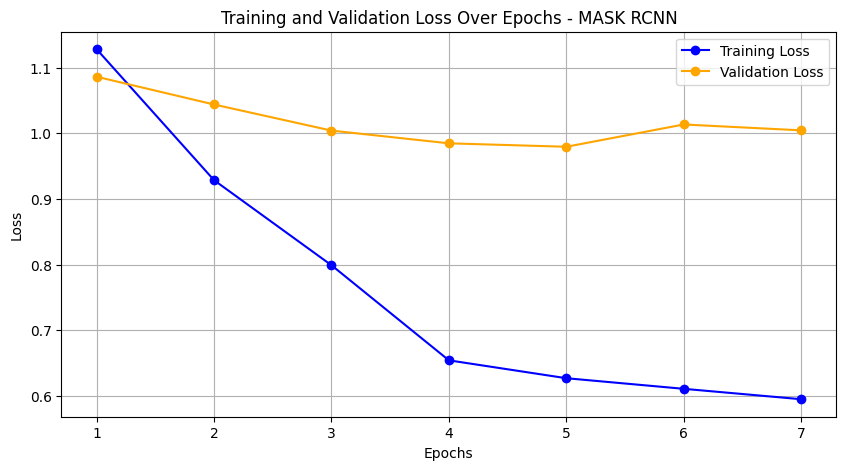

In [27]:
plot_losses(train_losses, val_losses)

Proveravamo rezultate koje smo dobili na validacionom skupu.

lopta: 0.19088305532932281
Ukupne metrike:
Metrička vrednost       Vrednost
              map tensor(0.4818)
           map_50 tensor(0.8159)
           map_75 tensor(0.4581)
        map_small tensor(0.0954)
       map_medium tensor(0.3579)
        map_large tensor(0.5486)
            mar_1 tensor(0.4270)
           mar_10 tensor(0.5399)
          mar_100 tensor(0.5517)
        mar_small tensor(0.1240)
       mar_medium tensor(0.3966)
        mar_large tensor(0.6238)

Metrike po klasama:
 ID klase               Klasa    map  mar_100
        1              Player 0.4367   0.5095
        2                Ball 0.1909   0.2481
        3           Goal Line 0.4476   0.5056
        4               Field 0.6553   0.7560
        5          Background 0.7406   0.8213
        6             Referee 0.6124   0.6612
        7 Football Pitch Line 0.2888   0.3600


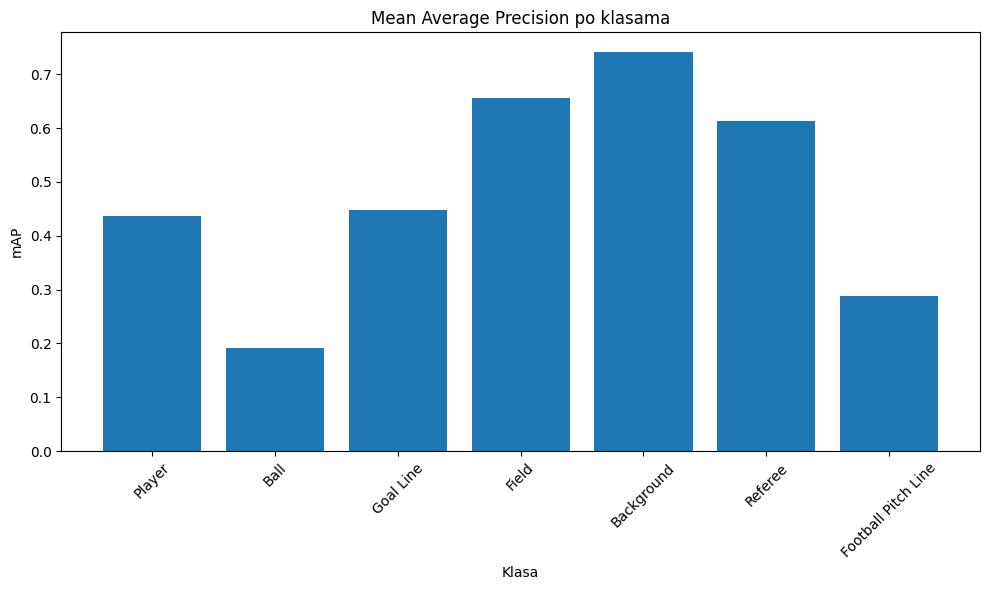

In [28]:
categories = {
    1: "Player",
    2: "Ball",
    3: "Goal Line",
    4: "Field",
    5: "Background",
    6: "Referee",
    7: "Football Pitch Line",
}

test(model, 'cuda', val_loader)

## Testiranje modela

In [ ]:
test_dataset = CustomDataset(IMAGES_DIR, [
    TEST_ANNOTATION
], transforms=T.Compose([T.ToTensor()]))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

test(model, 'cuda', test_loader)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


KeyboardInterrupt: 

## Predikcije na pojedinacnim slikama

In [ ]:


# setting model priorities for properly mask drawing
priorities = {
    1 : 6, # player
    2 : 7, # ball
    3 : 4, # goal line
    4 : 2, # field
    5 : 1, # background
    6 : 5, # refree
    7 : 3, # pitch line
    0 : 0
}

In [ ]:
#def load_model(model_path, num_classes):
#    model = get_instance_segmentation_model(num_classes)
#    model.load_state_dict(torch.load(model_path))
#    model.eval()
#    return model

def predict(model, image_path, device):
    image = Image.open(image_path).convert("RGB")

    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        prediction = model(image_tensor.to(device))

    return image, prediction

In [ ]:
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn

In [ ]:
def set_priorities(prediction, priorities):
    predictions_with_priorities = []
    for element in range(len(prediction[0]['boxes'])):
        box = prediction[0]['boxes'][element].cpu().numpy()
        score = prediction[0]['scores'][element].cpu().numpy()
        label_id = int(prediction[0]['labels'][element].cpu().numpy())
        mask = prediction[0]['masks'][element, 0].cpu().numpy()
        priority = priorities.get(label_id, 0)
        predictions_with_priorities.append((priority, box, score, label_id, mask))

    predictions_with_priorities.sort(key=lambda x: x[0])
    return predictions_with_priorities

def predict_and_visualize(image_path, model, device, draw_mask = True, draw_box = True):

    image, prediction = predict(model, image_path, device)

    predictions_with_priorities = set_priorities(prediction, priorities)

    combined_mask = np.zeros_like(image, dtype=np.float32)

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    if draw_mask:
        for priority, box, score, label_id, mask in predictions_with_priorities:
            label = categories.get(label_id, 'Unknown')

            if score > 0.5:
                mask = mask > 0.5
                random_color = np.random.rand(3)
                colored_mask = np.zeros((*mask.shape, 3))
                colored_mask[mask] = random_color
                combined_mask[mask] = random_color


        combined_mask = np.clip(combined_mask, 0, 1)
        ax.imshow(combined_mask, alpha=0.5)

    if draw_box:
        for priority, box, score, label_id, mask in predictions_with_priorities:
            label = categories.get(label_id, 'Unknown')

            if score > 0.5:
                rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(box[0], box[1] - 10, f'{label}: {score:.2f}', color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

In [ ]:
predict_and_visualize("./archive/images/Football batch 3.mp4_00033.jpg", model, device, draw_box=True, draw_mask=True)

NameError: name 'predict_and_visualize' is not defined

## Prosirivanje skupa podataka

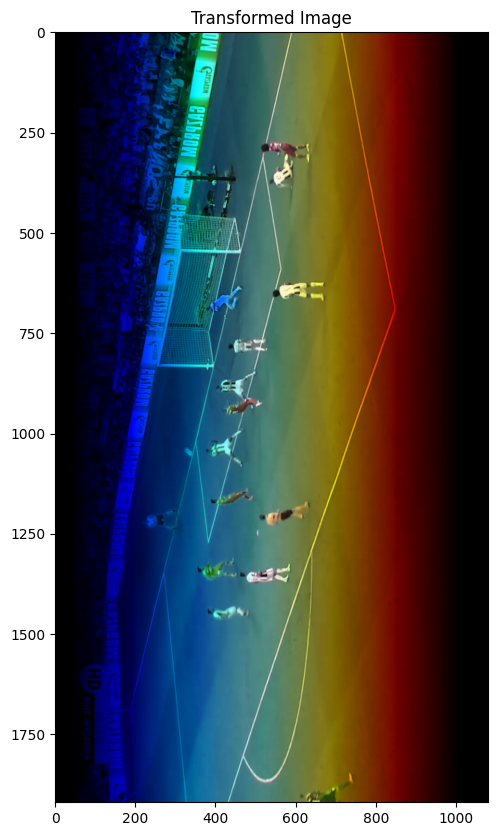

In [ ]:
from codes.mask_rcnn.augmented_set import DatasetAugs

width, height = 1920, 1080
# transformations_list
geom_transforms =  [A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=5,
                       interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=0.5),

                    A.HorizontalFlip(p=0.5),
                    A.RandomSizedCrop((800, 1070), height, width, w2h_ratio=1920/1080,
                                        interpolation=cv2.INTER_CUBIC, always_apply=False, p=0.5),
                    #A.Normalize(),
                    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
                    ]

In [ ]:
augmented_train_dataset = DatasetAugs(IMAGE_DIR, [TRAIN_ANNOTATION], geom_transforms)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
model = get_instance_segmentation_model(NUM_CLASSES)
model.to('cpu')

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 5

In [ ]:
model, train_losses, val_losses, map_values_bbox  = train(model, train_loader, val_loader, optimizer, lr_scheduler, num_epochs)

In [ ]:
save_model(
    model,
    optimizer,
    val_losses,
    train_losses,
    optimizer.param_groups[0]['lr'],
    num_epochs,
    train_loader.batch_size,
    str(model),
    MODEL_DIR_PATH,
    len(train_loader.dataset),
    len(val_loader.dataset),
    [tensor.item() if tensor.numel() == 1 else tensor.tolist() for tensor in map_values_bbox],
    'mask_rcnn_test',
    optimizer_hyperparameters=str(optimizer.defaults)
)

In [ ]:
test(model, 'cuda', data_path=IMAGES_DIR, annotation_paths=[TEST_ANNOTATION])